# Importando pacotes

In [1]:
import pywt
import numpy as np
import scipy.signal as signal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.fftpack import fft

# Importando dataset

In [2]:
files = ['1589679298-1589679343.csv','1589705079-1589705146.csv','1589730864-1589730930.csv',
         '1589682974-1589683028.csv','1589708764-1589708830.csv','1589734547-1589734613.csv',
         '1589686645-1589686713.csv','1589712447-1589712513.csv','1589738236-1589738304.csv',
         '1589690330-1589690396.csv','1589716130-1589716198.csv','1589741926-1589741992.csv',
         '1589694024-1589694091.csv','1589719814-1589719881.csv','1589745611-1589745678.csv',
         '1589697708-1589697775.csv','1589723497-1589723562.csv','1589749293-1589749360.csv',
         '1589701392-1589701458.csv','1589727180-1589727247.csv']
git = 'https://raw.githubusercontent.com/leandrofturi/espectroGeladeira/master/coleta/'
dfs = {f.split('.')[0]: pd.read_csv(git+f, header=None) for f in files} # lendo todos os arquivos .csv

In [3]:
# adicionando a coluna epoch, supondo-se que os intervalos entre cada medição é linear
for k, df in dfs.items():
    df.rename(columns={0: 'x', 1: 'y', 2: 'z', 3: 'c'}, inplace=True)
    df['epoch'] = np.linspace(int(k.split('-')[0]), int(k.split('-')[1]), num=len(df.index))

# Análise espectral

In [4]:
# Transformada de Fourier
def get_fft_values(y_values, dt, N):
    N2 = 2 ** (int(np.log2(N)) + 1) # arredondar para a próxima maior potência de 2
    f_values = np.linspace(0.0, 1.0/(2.0*dt), N2//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N2 * np.abs(fft_values_[0:N2//2])
    return f_values, fft_values

In [5]:
# Timesteps
# Como a quantidade de medições de cada conjunto de dados é diferente, cada um desses possui o seu passo de tempo
timesteps = [(int(k.split('-')[1]) - int(k.split('-')[0]))/(len(df.index)-1) for k, df in dfs.items()]
print(timesteps)

[0.003536067892503536, 0.0052557263884530905, 0.005185825410544511, 0.004224690971678924, 0.005155041787081153, 0.005172819186456619, 0.0053237297424254286, 0.005146600124766063, 0.005341292907077213, 0.005198487712665407, 0.005328735992477078, 0.005180127148575465, 0.005252842022736182, 0.005248726987857423, 0.005220508025557114, 0.005242566510172144, 0.005133875681225811, 0.005249960821187901, 0.005166744950681071, 0.005274344642997717]


In [6]:
# Plot da Transformada Fourier e seu Espectro de Potência
def plot_fft_plus_power(ax, signal, dt, N):
    fs = 1/dt
    variance = np.std(signal)**2
    f_values, fft_values = get_fft_values(signal, dt, N)
    f_values, fft_values = f_values[1:], fft_values[1:] # removing frequency equals to zero
    fft_power = variance * abs(fft_values) ** 2
    ax.plot(f_values, fft_values, 'r-', label='Fourier Transform') # em preto, a transformada Fourier
    ax.plot(f_values, fft_power, 'k--', label='FFT Power Spectrum') # em vermelho, o espectro de potência

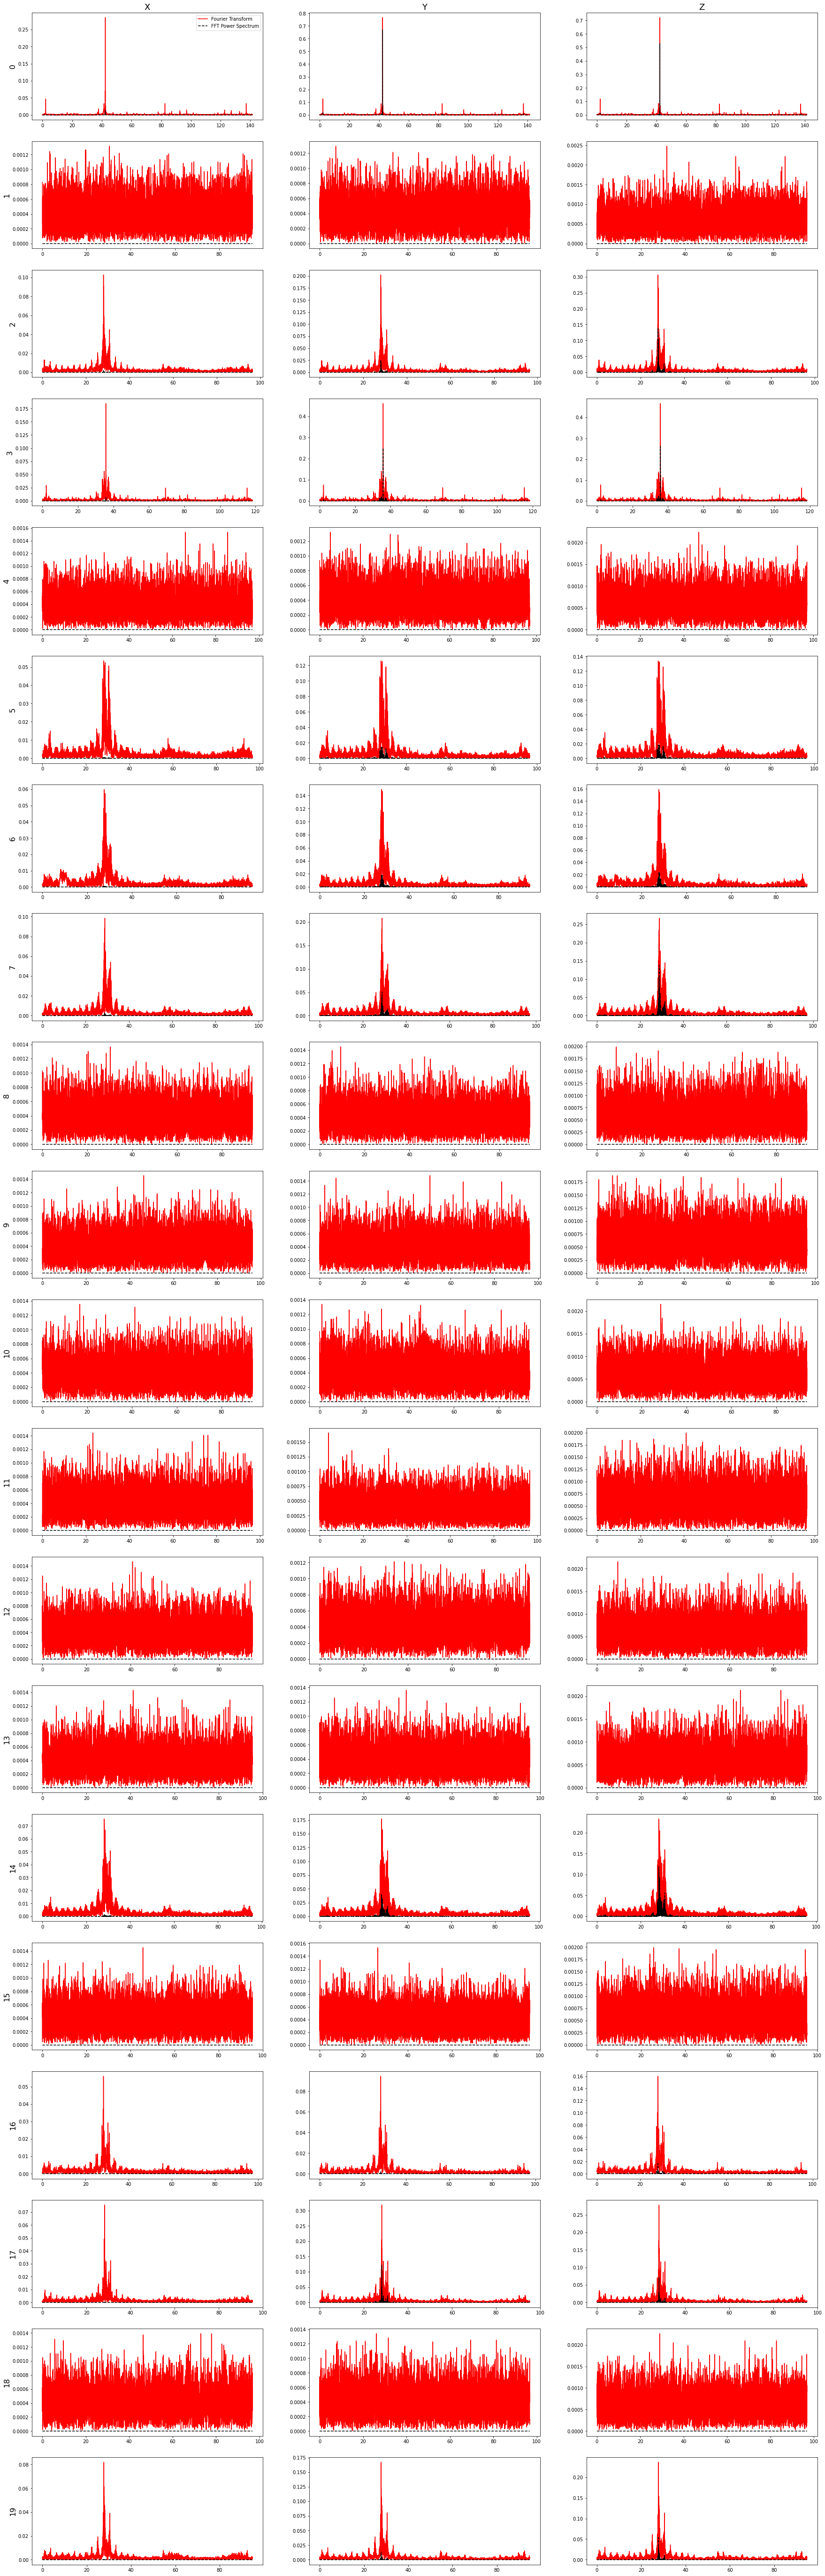

In [7]:
plt.rcParams.update({'figure.figsize': (30, 100)})

nrow = len(dfs)
iterator = iter(zip(dfs.values(), range(nrow), timesteps))

# Inserindo as legendas
df, i, dt = next(iterator)
N = len(df.index)

ax = plt.subplot(nrow, 3, 1)
plot_fft_plus_power(ax, df['x'].values, dt, N)
ax.set_title('X', fontsize=18)
ax.set_ylabel(str(i), fontsize=16)
ax.legend()

ax = plt.subplot(nrow, 3, 2)
plot_fft_plus_power(ax, df['y'].values, dt, N)
ax.set_title('Y', fontsize=18)

ax = plt.subplot(nrow, 3, 3)
plot_fft_plus_power(ax, df['z'].values, dt, N)
ax.set_title('Z', fontsize=18)

for df, i, dt in iterator:
    N = len(df.index)

    ax = plt.subplot(nrow, 3, 3*i+1)
    plot_fft_plus_power(ax, df['x'].values, dt, N)
    ax.set_ylabel(str(i), fontsize=16)
    plot_fft_plus_power(plt.subplot(nrow, 3, 3*i+2), df['y'].values, dt, N)
    plot_fft_plus_power(plt.subplot(nrow, 3, 3*i+3), df['z'].values, dt, N)

Certamente existe algo acontecendo em frequências entre 20 e 40 Hz (Gráficos-linha 4, 5, 6, 8, 10, 11, 14, 15, 16, 17). Podem ser oscilações nos acelerômetros ou influências externas. Vamos investigar.

# Uptime e Downtime

Inicialmente vamos trabalhar removendo os ruídos das medições. Para isso, usaremos um filtro via Análise Wavelet. Wavelets, diferente da FFT, possuem localização no domínio do tempo e da frequência, permitindo assim distinguir componentes do sinal para tratá-lo.

Uma introdução à Wavelet pode ser encvontrada em https://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/

Acerca do Filtro utilizado https://pywavelets.readthedocs.io/en/latest/ref/dwt-discrete-wavelet-transform.html#multilevel-decomposition-using-wavedec e https://stackoverflow.com/questions/54619107/how-to-combine-wavelet-transform-and-frequency-filtering

Cada tipo de wavelet tem uma forma diferente, suavidade e compactação e é útil para um propósito diferente.

Nesta aplicação utilizamos wavelets da família Daubechies, cujas funções são comumente empregadas. Acerca da escala, à grosso modo quanto maior o valor, mais o nível de decomposição e o número de amostras que esta onda se expressa aumenta. Como o conjunto de dados não é muito grande, utilizaremos um alto grau de refinamento.

In [8]:
# Daubechies 30 order
def wavelet_filter(data, wavelet_type='db30'):
    DWTcoeffs = pywt.wavedec(data, wavelet_type, mode='symmetric', axis=-1)

    for i in range(len(DWTcoeffs)-1):
        DWTcoeffs[-i] = np.zeros_like(DWTcoeffs[-i])

    filtered = pywt.waverec(DWTcoeffs, wavelet_type, mode='symmetric', axis=-1)
    while len(filtered) < len(data):
        filtered = numpy.append(filtered, filtered[0])
    while len(filtered) > len(data):
        filtered = filtered[1:]
    return filtered

In [9]:
# Aplicando o filtro
for df in dfs.values():
    for c in ['x','y','z']:
        df[c+'_filtered'] = wavelet_filter(df[c].values)

In [10]:
# Valores max e min das colunas filtradas, para escalamento dos gráficos
df = pd.concat([df[['x_filtered','y_filtered','z_filtered']] for df in dfs.values()])
print(df.max())
print(df.min())

x_filtered    0.133593
y_filtered    0.248589
z_filtered    0.348012
dtype: float64
x_filtered   -0.121644
y_filtered   -0.222031
z_filtered   -0.339485
dtype: float64


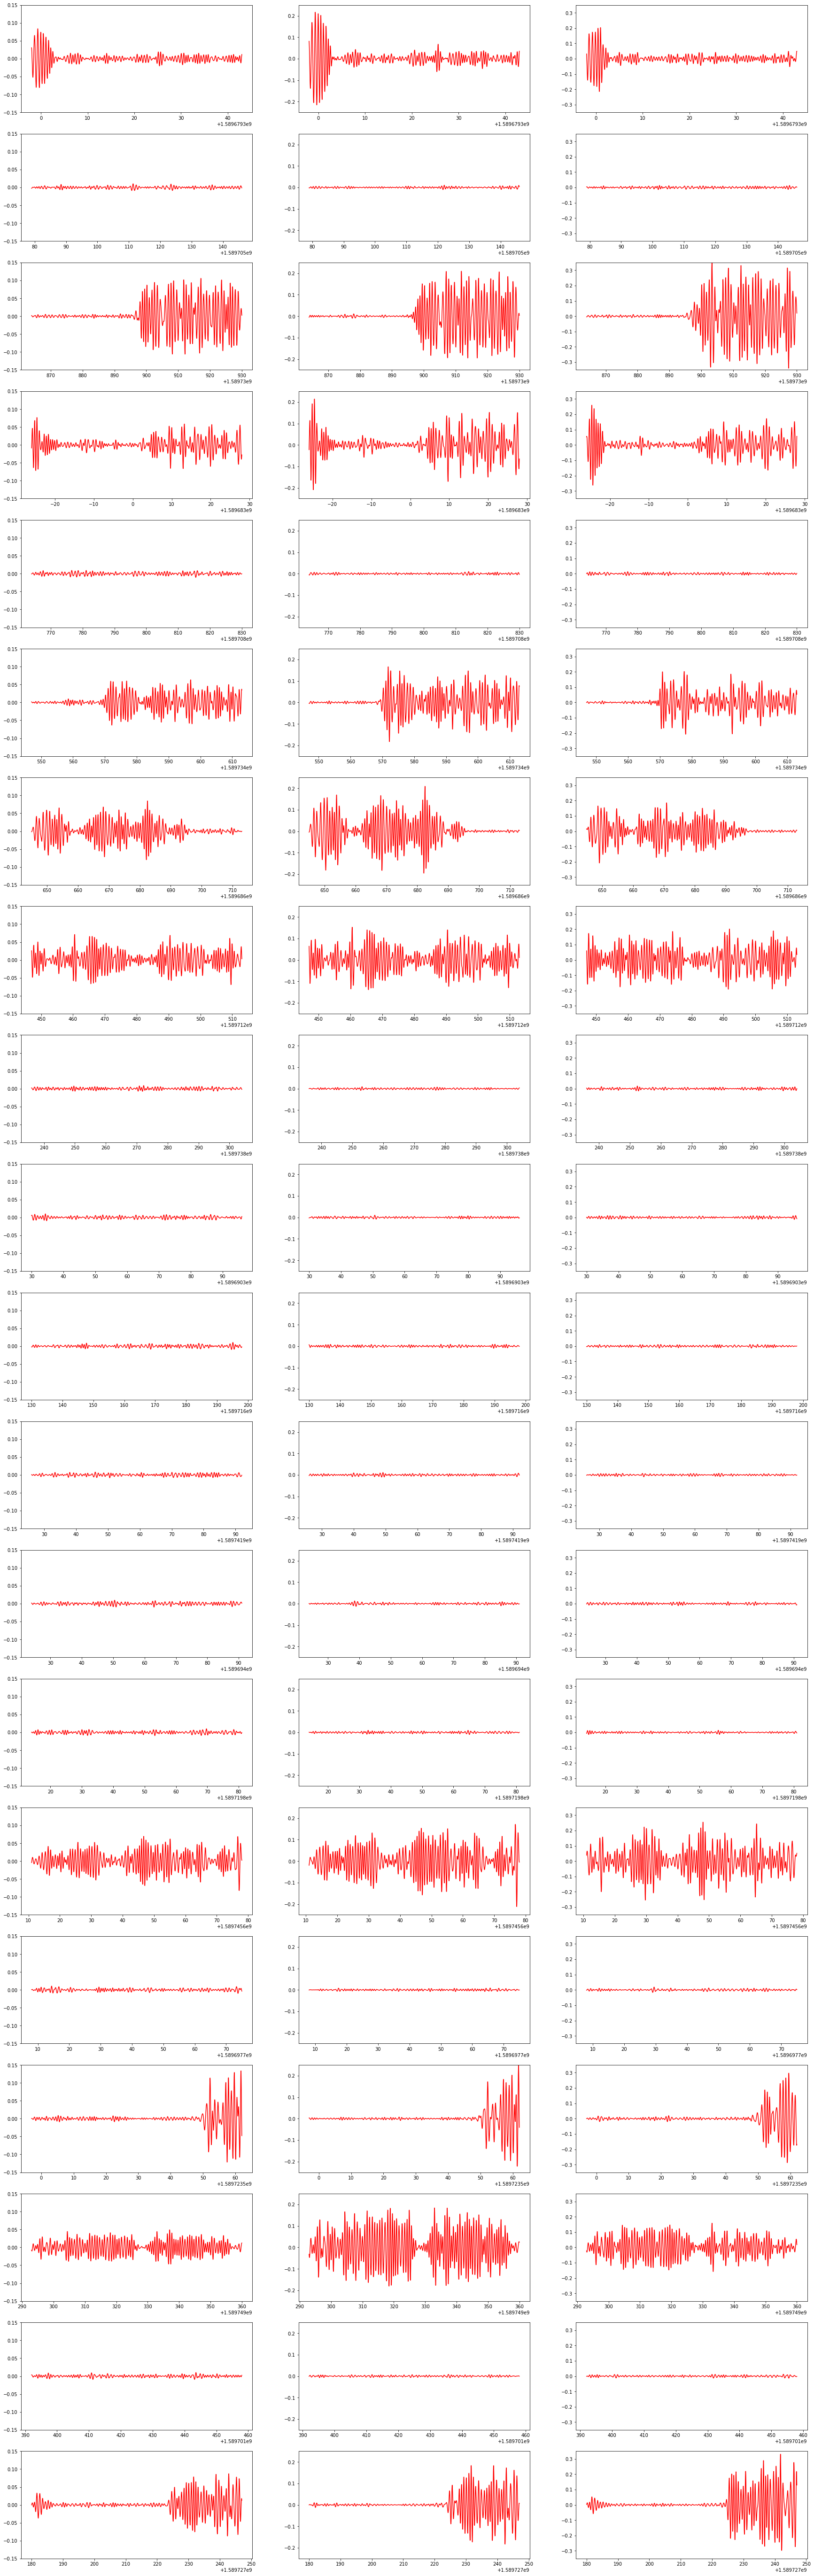

In [11]:
plt.rcParams.update({'figure.figsize': (30, 100)})

def plot_filtered_data(ax, time, data, ymax, ymin):
    ax.plot(time, data, color='red', label='filtered data (DWT)')
    ax.set_ylim(ymin, ymax)

nrow = len(dfs)

for df, i in zip(dfs.values(), range(nrow)):
    time = df['epoch']
    plot_filtered_data(plt.subplot(nrow, 3, 3*i+1), time, df['x_filtered'], 0.15, -0.15)
    plot_filtered_data(plt.subplot(nrow, 3, 3*i+2), time, df['y_filtered'], 0.25, -0.25)
    plot_filtered_data(plt.subplot(nrow, 3, 3*i+3), time, df['z_filtered'], 0.35, -0.35)

Como pode ser notado, o filtro utilizado performou de maneira adequada, removendo grande parte dos rúidos do sinal original. Entretanto, ainda restam valores bem próximos de zero que iremos terminar de aproximá-los manualmente.

Para isso, utilizaremos 10\% do escalamento definido para construção dos gráficos (relacionado aos valores máximos e mínimos de cada coluna) e consideraremos este intervalo como sendo nulo.

In [12]:
for df in dfs.values():
    df['x_filtered'][(df['x_filtered'] < 0.015) & (df['x_filtered'] > -0.015)] = 0.0
    df['y_filtered'][(df['y_filtered'] < 0.025) & (df['y_filtered'] > -0.025)] = 0.0
    df['z_filtered'][(df['z_filtered'] < 0.035) & (df['z_filtered'] > -0.035)] = 0.0

Vejemos como o filtro performou ao final

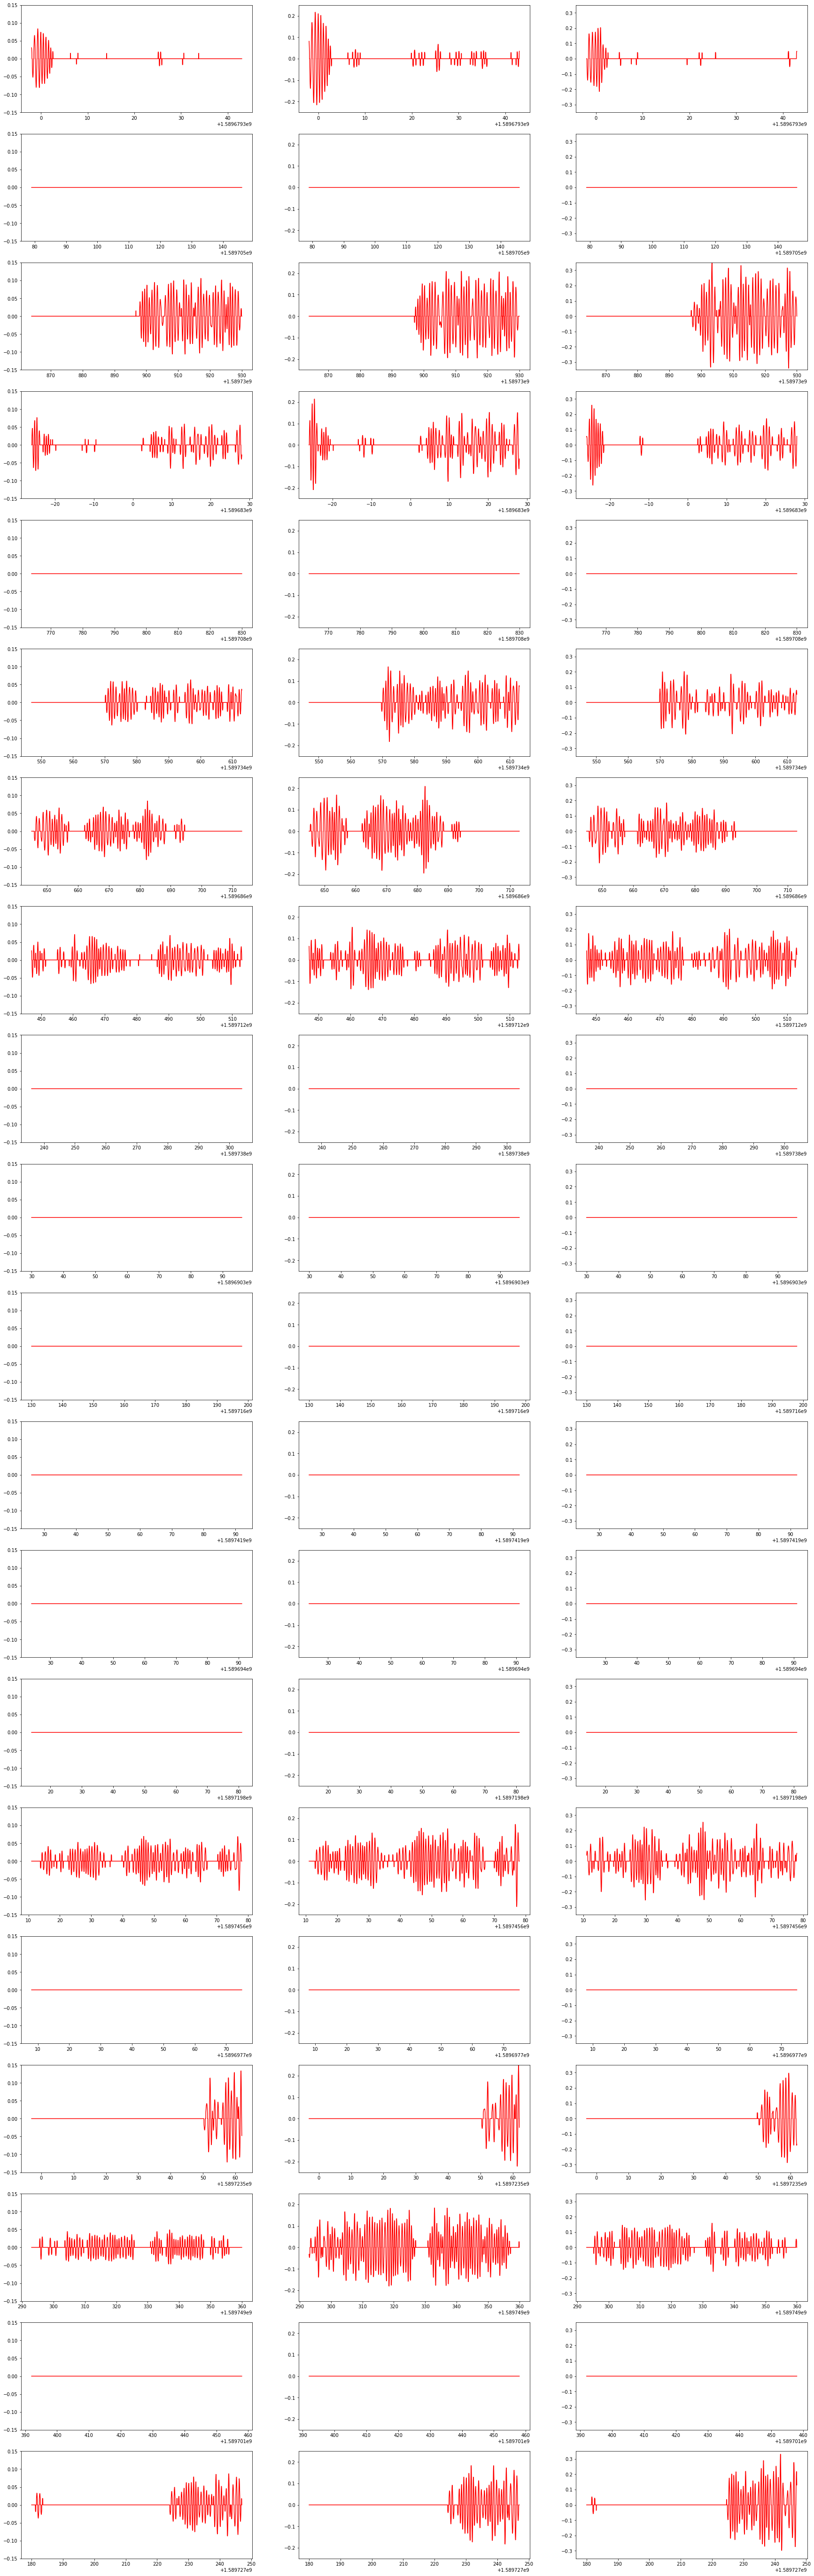

In [13]:
plt.rcParams.update({'figure.figsize': (30, 100)})

def plot_filtered_data(ax, time, data, ymax, ymin):
    ax.plot(time, data, color='red', label='filtered data (DWT)')
    ax.set_ylim(ymin, ymax)

nrow = len(dfs)

for df, i in zip(dfs.values(), range(nrow)):
    time = df['epoch']
    plot_filtered_data(plt.subplot(nrow, 3, 3*i+1), time, df['x_filtered'], 0.15, -0.15)
    plot_filtered_data(plt.subplot(nrow, 3, 3*i+2), time, df['y_filtered'], 0.25, -0.25)
    plot_filtered_data(plt.subplot(nrow, 3, 3*i+3), time, df['z_filtered'], 0.35, -0.35)

De fato, agora conseguimos distinguir os momentos em que os três acelerômetros estavam recebendo informações. Para computar quanto tempo a geladeira ficou ligada (uptime) e quanto tempo ela ficou desligada (downtime) basta verificar se os acelerômetros (agora tratados) estavam realizando alguma medição.

Por exemplo, podemos calcular a porcentagem de epochs em que a nossa geladeira permanecei ligada:

In [14]:
df = pd.concat([df[['epoch','x_filtered','y_filtered','z_filtered']] for df in dfs.values()])

total = df['epoch'].sum()
not_null = df['epoch'][df[['x_filtered','y_filtered','z_filtered']].any(axis=1)].sum()
print(not_null*100/total)

26.551812087047256


Acerca da condição do compressor da geladeira, realizaremos uma análise visual com os nossos dados tratados sobrepostos e escalados de acordo com os limites que definimos anteriormente.

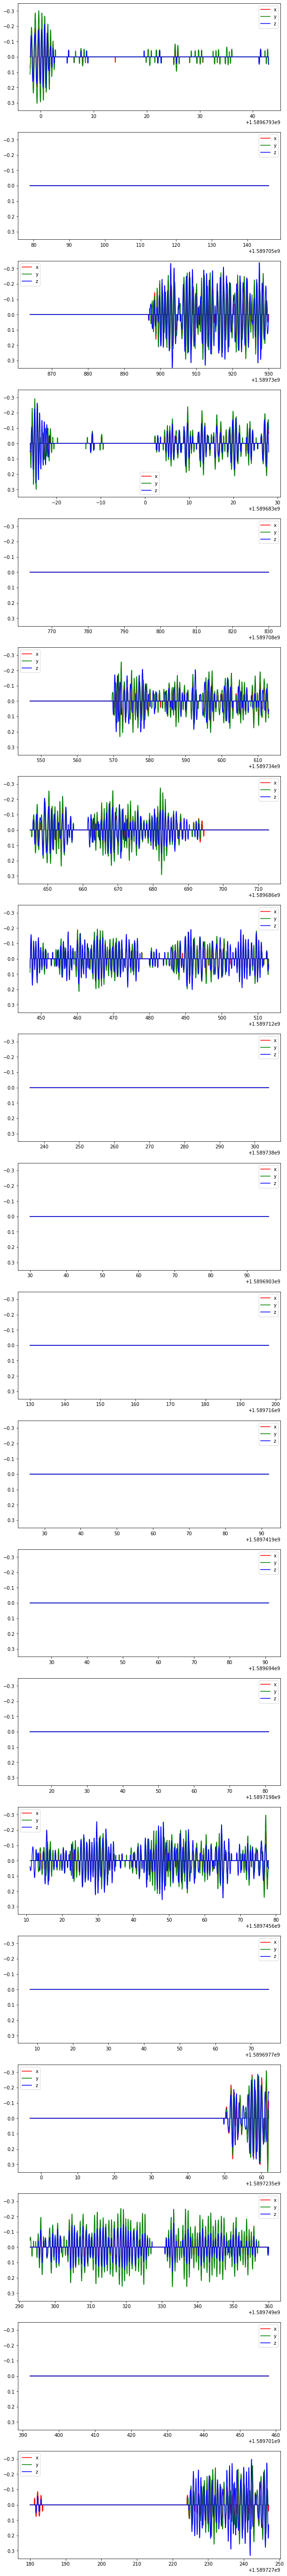

In [15]:
plt.rcParams.update({'figure.figsize': (10, 100)})

nrow = len(dfs)

for df, i in zip(dfs.values(), range(nrow)):
    time = df['epoch']

    ax = plt.subplot(nrow, 1, i+1)
    ax.plot(time, 2.333*df['x_filtered'], color='r', label='x') # escalado para 0.35/0.15
    ax.plot(time, 1.4*df['y_filtered'], color='g', label='y') # escalado para 0.25/0.15
    ax.plot(time, df['z_filtered'], color='b', label='z')
    ax.set_ylim(0.35, -0.35)
    ax.legend()

Retornando sobre a condição do compressor da geladeira, podemos deliberar que este encontra-se apenas desalinhado, visto que foi necessário apenas um escalamento para que os dados de cada um dos sensores apresentassem uma boa sobreposição, a saber, uma boa aproximação das escalas encontrada foi 0.15 em x; 0.25 em y; 0.35 em z.